In [ ]:
import pandas as pd
import gensim.downloader as api
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize
import re
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import gensim
import numpy as np
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
import keras
from keras.models import model_from_json


In [ ]:
import os
import glob

## Reading the data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv')
# from google.colab import files
# uploaded = files.upload()
# import io
# df2 = pd.read_csv(io.BytesIO('IMDB Dataset.csv'))

In [ ]:
# df = df.head(500)

### Google's word2vec model

In [ ]:

model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use

[=================================================-] 100.0% 1662.4/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Stanford's GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-10-04 18:47:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-04 18:47:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-04 18:47:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
path_to_glove_file = "/content/glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

### Self-trained GloVe

In [ ]:
pip install glove_python

     |████████████████████████████████| 266kB 3.4MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700265 sha256=fd8ff000547801a65f735e6d25c20746a22318bf7d43babf71f6dc9877007121
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


## Testing the word2vec

### Word vectors refers to all the words in the corpus

In [ ]:
word_vectors = model.wv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
# /# Load word2vec model (trained on an enormous Google corpus)
# download
# from gensim import models
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

## Identify all the words that are not present in the word2vec corpus and then start with the data preprocessing accordingly

## Tokenize sentences and create a word corpus

---



### Should remove punctuations, numbers and HTML tags

In [ ]:
# out_of_domain = pd.read_csv('/content/drive/My Drive/out_of_domain.csv')

In [ ]:
s_words = stopwords.words('english')
def preprocess(text):
    new_text = re.sub('<.*?>', ' ', text)   # remove HTML tags
    new_text = re.sub(r'[^\w\s]', ' ', new_text) # remove punc.
    new_text = re.sub(r'_', ' ', new_text) # remove punc.
    new_text = re.sub(r'\d+',' ',new_text)# remove numbers
    new_text = new_text.lower() # lower case, .upper() for upper    
    word_tokens = word_tokenize(new_text) 
    new_text = ' '.join([w for w in word_tokens if w not in s_words]) 
    return new_text
    

In [ ]:
def remove_s_words(text):
    word_tokens = word_tokenize(text) 
    new_text = ' '.join([w for w in word_tokens if w not in s_words]) 
    return new_text

In [ ]:
df['review'] = df['review'].apply(lambda x: preprocess(x)) 

In [ ]:
google_flag = 0
stanford_flag = 0

### out of domain words if pre-trained models are being used




In [ ]:
corpus = word_tokenize(" ".join(df.iloc[:,0]))
corpus = list(set(corpus))
if google_flag==1:
  out_of_domain = []
  for i in corpus:
    if i not in word_vectors:
      out_of_domain = out_of_domain+[i]
    else:
      continue 

if stanford_flag==1:
  out_of_domain = []
  word_vectors = list(embeddings_index.values())
  for i in corpus:
    if i not in word_vectors:
      out_of_domain = out_of_domain+[i]
    else:
      continue 


def ood(text):
  word_tokens = word_tokenize(text) 
  new_text = ' '.join([w for w in word_tokens if w not in out_of_domain])
  return new_text

  
if google_flag==1:
  df['review'] = df['review'].apply(lambda x: ood(x)) 
  corpus = word_tokenize(" ".join(df.iloc[:,0]))
  corpus = list(set(corpus))

if stanford_flag==1:
  df['review'] = df['review'].apply(lambda x: ood(x)) 
  corpus = word_tokenize(" ".join(df.iloc[:,0]))
  corpus = list(set(corpus))

In [ ]:
# len(out_of_domain)/(len(corpus)+len(out_of_domain))*100

In [ ]:
len(corpus)

99713

### Fitting the GloVe model

In [ ]:
from glove import Corpus, Glove
#Creating a corpus object
corp = Corpus() 
#Training the corpus to generate the co occurence matrix which is used in GloVe
lines =  list(df['review'].apply(lambda x: word_tokenize(x)))
corp.fit(lines, window=10)

glove = Glove(no_components=300, learning_rate=0.05)
glove.fit(corp.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corp.dictionary)

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [ ]:
embedding_index = {}
for i in corpus:
  coefs = glove.word_vectors[glove.dictionary[i]]
  embedding_index[i] = coefs

### Fitting the word2vec model

In [ ]:
import multiprocessing as mp

In [ ]:
vector_size = 300
maxlen = 64
n_iterations = 10  # ideally more..
n_exposures = 30
window_size = 5
batch_size = 32
n_epoch = 2
input_length = 50
cpu_count = mp.cpu_count()
sg=0


In [ ]:
df['tokenized_review'] = df['review'].apply(lambda x: word_tokenize(x))


In [ ]:
model = Word2Vec()
model.build_vocab(df['tokenized_review'].values)
model = gensim.models.Word2Vec(df['tokenized_review'].values, min_count = 2,  size = vector_size, window = window_size,sg=sg) 

# gensim_dict = Dictionary()
# gensim_dict.doc2bow(corpus,allow_update=True)
# w2indx = {v: k+1 for k, v in gensim_dict.items()}
# w2vec = {word: model[word] for word in w2indx.keys()}
# embedding_len = len(w2vec['movie'])
# vocab_dim = len(corpus)

In [ ]:
w2vec_corpus = list(model.wv.vocab.keys())

In [ ]:
gensim_dict = Dictionary()
gensim_dict.doc2bow(w2vec_corpus,allow_update=True)
w2indx = {v: k+1 for k, v in gensim_dict.items()}
w2vec = {word: model[word] for word in w2indx.keys()}
embedding_len = len(w2vec['movie'])
vocab_dim = len(corpus)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


# Word Analogy Task for evaluating WORD EMBEDDINGS trained on Word2Vec

### First read all the words given in the documents that I have 

In [ ]:
# Step 1: get a list of all csv files in target directory
# final_analogy = pd.DataFrame(columns = ['word','semantic'])
final_analogy_df = pd.DataFrame()

# for k in ['3_Encyclopedic_semantics','4_Lexicographic_semantics']:
my_dir = "/content/"
filelist = []
filesList = []
os.chdir( my_dir )

# Step 2: Build up list of files:
for files in glob.glob("*.txt"):
  fileName, fileExtension = os.path.splitext(files)
  filesList.append(files) #filename with extension

  # Step 3: Build up DataFrame:
analogy_df = pd.DataFrame()
for i in filesList:
  analogy_df = pd.read_csv(i, sep="\t", header=None)
  # analogy_df = analogy_df.append(frame)
  analogy_df['file_name'] = i
  final_analogy_df = pd.concat([analogy_df, final_analogy_df])

In [ ]:
final_analogy_df.columns = ['word','meaning','file_name']
coverage_df = final_analogy_df[final_analogy_df['word'].isin(corpus)]

In [ ]:
def corpus_filter(text):
  text_list = text.split('/')
  temp_text_list = []
  for i in text_list:
    if i in corpus:
      temp_text_list = temp_text_list + [i]
      # print (temp_text_list)
  return (temp_text_list)      

In [ ]:
coverage_df['meaning'] = coverage_df['meaning'].apply(lambda x: corpus_filter(x))
coverage_df['len_meaning'] = coverage_df['meaning'].apply(lambda x:len(x))
coverage_df = coverage_df[coverage_df['len_meaning']!=0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
def analogy(x1,x2,y1,y2):
  lis = []
  for i in x2:
    try:
      result = model.wv.most_similar(negative=[i], 
                                  positive=[x1, y1])
      # return (result)
      length = len(result)
      # return (result)
      result  = [result[j][0] for j in range(0,length)]
      # print(str(x1)+' + '+str(y1)+' - '+str(i)+' = ') 
      # print (result)
      result = list(set(result).intersection(set(y2)))
      if len(result)>0:
        lis+=[1]
      else:
        lis+=[0]
    except:
      lis+=['OOV']
    return (lis)

In [ ]:
coverage_df.columns = ['word1','meaning1','file_name','len1']
coverage_df_copy = coverage_df.copy()
coverage_df_copy.columns = ['word2','meaning2','file_name','len2']
queries = coverage_df.merge(coverage_df_copy,how = 'outer',on = 'file_name')
# queries.drop(columns = 'key', inplace = True)

NameError: ignored

In [ ]:
# queries.to_csv('\content\word_analogy_queries.csv', index = False)
queries = pd.read_csv('/content/drive/My Drive/word_analogy_queries.csv')

In [ ]:
import ast
window = [7,10]
min_count = [2,3,6,18]
size = [50,100,200,300,400]
sg = [0,1]
eval_df = pd.DataFrame(columns = ['win', 'mc', 'sz','s_or_g', 'ided','correct','percentage'])
ctr = 1
for win in window:
  for mc in min_count:
    for sz in size:
      for s_or_g in sg:
        print ('Model Creation started!')
        model = Word2Vec()
        model.build_vocab(df['tokenized_review'].values)
        model = gensim.models.Word2Vec(df['tokenized_review'].values, min_count = mc,  size = sz, window = win, sg = s_or_g) 
        # gensim_dict = Dictionary()
        # gensim_dict.doc2bow(corpus,allow_update=True)
        # w2indx = {v: k+1 for k, v in gensim_dict.items()}
        # w2vec = {word: model[word] for word in w2indx.keys()}
        # embedding_len = len(w2vec['movie'])
        vocab_dim = len(corpus)
        output = []
        print ('Model has been created!!')

        for i in range(0,len(queries)):
          if i%10000==0:
            print (str(round(ctr*100/80,2))+str('% Complete!')) 
            eval_df.to_csv('/content/drive/My Drive/word2vec_eval_2.csv', index = False)

          word1 = queries.iloc[i,0]
          meaning1 = queries.iloc[i,1]
          word2 = queries.iloc[i,4]
          meaning2 = queries.iloc[i,5]
          meaning1 = ast.literal_eval(meaning1) 
          meaning2 = ast.literal_eval(meaning2) 
          out = analogy(word1,meaning1,word2,meaning2)
          output+=out
        mod_output = [x for x in output if x!='OOV']
        ided = len(mod_output)
        correct = sum(mod_output)
        percentage = correct*100.0/ided
        eval_df = eval_df.append({'win':win,'mc':mc,'sz':sz,'s_or_g':s_or_g,'ided':ided,
                                  'correct':correct,'percentage':percentage}, ignore_index = True)
        ctr+=1

Model Creation started!
Model has been created!!
0.62% Complete!


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.62% Complete!
0.62% Complete!
0.62% Complete!
Model Creation started!
Model has been created!!
1.25% Complete!
1.25% Complete!
1.25% Complete!
1.25% Complete!
Model Creation started!
Model has been created!!
1.88% Complete!
1.88% Complete!
1.88% Complete!
1.88% Complete!
Model Creation started!
Model has been created!!
2.5% Complete!
2.5% Complete!
2.5% Complete!
2.5% Complete!
Model Creation started!
Model has been created!!
3.12% Complete!
3.12% Complete!
3.12% Complete!
3.12% Complete!
Model Creation started!
Model has been created!!
3.75% Complete!
3.75% Complete!
3.75% Complete!
3.75% Complete!
Model Creation started!
Model has been created!!
4.38% Complete!
4.38% Complete!
4.38% Complete!
4.38% Complete!
Model Creation started!
Model has been created!!
5.0% Complete!
5.0% Complete!
5.0% Complete!
5.0% Complete!
Model Creation started!
Model has been created!!
5.62% Complete!
5.62% Complete!
5.62% Complete!
5.62% Complete!
Model Creation started!
Model has been created!!
6.25% C

In [ ]:
eval_df.to_csv('/content/drive/My Drive/word2vec_eval.csv', index = False)

NameError: ignored

# Converting the reviews into word vectors

In [ ]:
glove = 0

In [ ]:
df['review'] = df['review'].apply(lambda x: remove_s_words(x)) 
df['review'] = df['review'].apply(lambda x: ' '.join([i for i in word_tokenize(x)]))
if glove==0:
  df['token_vectors'] = df['review'].apply(lambda x: [w2vec[i] for i in word_tokenize(x) if i in w2vec.keys()])
else:
  w2indx = dict(zip(embedding_index.keys(), [i for i in range(1,len(list(embedding_index.keys())))]))
  w2vec = embedding_index
  df['token_vectors'] = df['review'].apply(lambda x: [w2vec[i] for i in word_tokenize(x) if i in w2vec.keys()])

## Skip

### Setting up word frequency

In [ ]:
import itertools
import collections
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
tokens = word_tokenize(" ".join(df.iloc[:,0]))
# all_words_no_urls = list(itertools.chain(*words_in_tweet))
tokens_freq = collections.Counter(tokens)

##### List of tuples to data frame

In [ ]:
tokens_df = pd.DataFrame(tokens_freq.most_common(),
                             columns=['words', 'count'])

In [ ]:
len(tokens_df[tokens_df['count']>2])

50171

In [ ]:
vl = len(tokens_df[tokens_df['count']>2])

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(250, 250))
# # Plot horizontal bar graph
# tokens_df.sort_values(by='count').plot.barh(x='words',
#                       y='count',
#                       ax=ax,
#                       color="purple")

# ax.set_title("Words Frequency")
# plt.show()

## Top n thousand words

### Setting the embedding weights of top 5000 words with word2vec 

In [ ]:
glove_flag = 0

In [ ]:
if glove_flag==1:
  vector_size = len(w2vec['movie'])

In [ ]:
embed_length = vl+1
vocab_size = embed_length 
n_symbols = len(corpus) + 1  
oov_tok = '<OOV>'

In [ ]:
tokenizer = Tokenizer(num_words = embed_length, oov_token=oov_tok)
tokenizer.fit_on_texts(df['review'])
word_index = tokenizer.word_index

#### Creating a dictionary with top 5000 words only

In [ ]:
top_word_index = {i:j for i,j in word_index.items() if j<=embed_length}

In [ ]:
index_dict = w2indx
word_vectors = w2vec
embedding_weights = np.zeros((embed_length, vector_size))
word_index['<OOV>'] = 1

zero_embed = []

for word, index in top_word_index.items():
  if word not in word_vectors.keys():
    embedding_weights[index-1, :] = np.zeros(vector_size).shape
    zero_embed.extend([word])
  else:
    embedding_weights[index-1, :] = word_vectors[word]

### label encoding

In [ ]:
lb_maker = LabelEncoder()
df['sentiment']= lb_maker.fit_transform(df['sentiment'])

### Fitting on texts

In [ ]:
trunc_type = 'post'
padding_type = 'post'

#### Checking if each word is within 5000 limit or not

In [ ]:
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= vocab_size} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] =  1

In [ ]:
all_sequences = tokenizer.texts_to_sequences(df['review'].values)
all_padded = pad_sequences(all_sequences, maxlen=vector_size, padding=padding_type, truncating=trunc_type)
labels = df['sentiment']
all_label_seq = np.array(labels)


### Train test split "A" with fixed vocab length

In [ ]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(all_padded, all_label_seq, train_size=0.65,test_size=0.35, random_state=101)


### Train test split "B" with full vocab length

In [ ]:
maxlen = 1420

In [ ]:
X = df['token_vectors'].values
y = df['sentiment'].values

import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.65,test_size=0.35, random_state=101)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen, dtype = 'float')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, dtype='float')

### Creating LSTM and feeding input after test-train validation split

In [ ]:
# lstm_model = Sequential()  # or Graph 
# lstm_model.add(Embedding(output_dim=maxlen,
#                     input_dim=n_symbols,
#                     mask_zero=True,
#                     weights=[embedding_weights],
#                     input_length=input_length))  # Adding Input Length
# lstm_model.add(LSTM(maxlen))
# lstm_model.add(Dropout(0.3))
# lstm_model.add(Dense(1, activation='sigmoid'))

# print('Compiling the Model...')
# lstm_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# print("Train...")

Compiling the Model...
Train...


In [ ]:
max

1420

In [ ]:
max = 0
for i in range(0,len(X)):
  if len(X[i])>max:
    max = len(X[i])

Dense layer is of 100 dimension input and output is one or two

In [ ]:
X = all_padded
y = all_label_seq


### Defining K folds cross validation

In [ ]:
# Define per-fold score containers
embedding_dim = vector_size
num_epochs = 10
f1_per_fold = []
recall_per_fold = []
precision_per_fold = []
acc_per_fold = []
# Define the K-fold Cross Validator
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)


In [ ]:
fold_no = 1
for train, test in kfold.split(inputs, targets):
  lstm_model = Sequential()  # or Graph 
  lstm_model.add(Embedding(vocab_size, embedding_dim,weights= [embedding_weights]))  # Adding Input Length
  lstm_model.add(LSTM(embedding_dim))
  lstm_model.add(Dropout(0.3))
  lstm_model.add(Dense(1, activation='sigmoid'))

  print('Compiling the Model...')
  lstm_model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'], run_eagerly = True)

  print("Train...")
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = lstm_model.fit(inputs[train], targets[train], epochs=num_epochs, verbose=2, batch_size = 50)
  y_pred = lstm_model.predict_classes(inputs[test], verbose=0)
  y_probs = lstm_model.predict(inputs[test], verbose=0)
  y_probs = y_probs[:, 0]
  y_pred = y_pred[:, 0]
  #####################################################################################
  ##Evaluation Metrics
  y_test = targets[test]
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_test, y_pred)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test, y_pred)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, y_pred)
  print('F1 score: %f' % f1)

  f1_per_fold.append(round(f1*100,2))
  recall_per_fold.append(round(recall*100,2))
  precision_per_fold.append(round(precision*100,2))
  acc_per_fold.append(round(accuracy*100,2))
  # Increase fold number
  fold_no = fold_no + 1

Compiling the Model...
Train...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
900/900 - 2933s - loss: 0.4067 - accuracy: 0.8111
Epoch 2/10
900/900 - 2933s - loss: 0.1810 - accuracy: 0.9348
Epoch 3/10
900/900 - 2952s - loss: 0.0871 - accuracy: 0.9719
Epoch 4/10
900/900 - 2955s - loss: 0.0393 - accuracy: 0.9888
Epoch 5/10
900/900 - 2939s - loss: 0.0213 - accuracy: 0.9942
Epoch 6/10
900/900 - 2933s - loss: 0.0168 - accuracy: 0.9956
Epoch 7/10
900/900 - 2958s - loss: 0.0113 - accuracy: 0.9967
Epoch 8/10
900/900 - 2970s - loss: 0.0102 - accuracy: 0.9967
Epoch 9/10
900/900 - 2975s - loss: 0.0065 - accuracy: 0.9984
Epoch 10/10
900/900 - 2988s - loss: 0.0044 - accuracy: 0.9987
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does bin

In [ ]:
np.mean(f1_per_fold)

NameError: ignored

### Model save

In [ ]:
model_name = 'model_2.json'
model_weights = 'model_2_wt.h5'
model_json = lstm_model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights(model_weights)
print("Saved model to disk")

Saved model to disk


### Model Load

In [ ]:
model_name = 'model_1.json'
model_weights = 'model_1_wt.h5'

# load json and create model
json_file = open(model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_weights)
print("Loaded model from disk")

Loaded model from disk


### Model without K fold

In [ ]:
lstm_model = Sequential()  # or Graph 
lstm_model.add(Embedding(vocab_size, embedding_dim,weights= [embedding_weights]))  # Adding Input Length
lstm_model.add(LSTM(embedding_dim))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))

print('Compiling the Model...')
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'], run_eagerly = True)

print("Train...")


Compiling the Model...
Train...


In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=num_epochs, verbose=2, batch_size = 50)

Epoch 1/10
7/7 - 3s - loss: 0.7228 - accuracy: 0.5015
Epoch 2/10
7/7 - 3s - loss: 0.7164 - accuracy: 0.5231
Epoch 3/10
7/7 - 3s - loss: 0.7143 - accuracy: 0.5200
Epoch 4/10
7/7 - 3s - loss: 0.7100 - accuracy: 0.5138
Epoch 5/10
7/7 - 3s - loss: 0.7080 - accuracy: 0.4954
Epoch 6/10
7/7 - 3s - loss: 0.6970 - accuracy: 0.5415
Epoch 7/10
7/7 - 3s - loss: 0.7010 - accuracy: 0.5446
Epoch 8/10
7/7 - 3s - loss: 0.6694 - accuracy: 0.5846
Epoch 9/10
7/7 - 3s - loss: 0.6669 - accuracy: 0.5908
Epoch 10/10
7/7 - 3s - loss: 0.6425 - accuracy: 0.6431


### Model testing 

In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
y_pred = lstm_model.predict_classes(X_test, verbose=0)
y_probs = lstm_model.predict(X_test, verbose=0)
y_probs = y_probs[:, 0]
y_pred = y_pred[:, 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.617143
Precision: 0.592233
Recall: 0.709302
F1 score: 0.645503


In [ ]:
y_pred

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
      dtype=int32)

#### Checking the content of word embeddings

In [ ]:
# max = 0
# min = 1
# flag = 0
# for i in range(0,500):
#   if 4999 in X[i]:
#     flag = 1
#   if X[i].max()>max:
#     max = X[i].max()
#   if X[i].min()<min:
#     min = X[i].min()  

In [ ]:
# lstm_model = Sequential()  # or Graph 
# lstm_model.add(Embedding(output_dim=maxlen,
#                     input_dim=n_symbols,
#                     mask_zero=True,
#                     weights=[embedding_weights]))  # Adding Input Length
# lstm_model.add(LSTM(maxlen, input_shape = (None, 50,50,50), return_sequences=True))
# lstm_model.add(Dropout(0.3))
# lstm_model.add(Dense(1, activation='sigmoid'))

# print('Compiling the Model...')
# lstm_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'], run_eagerly = True)

# print("Train...")

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

(32500, 50, 50)

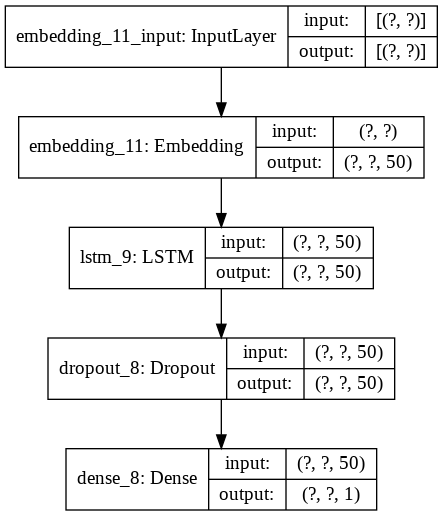

In [ ]:
keras.utils.plot_model(lstm_model, show_shapes=True)

In [ ]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 50)          10754200  
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,774,451
Trainable params: 10,774,451
Non-trainable params: 0
_________________________________________________________________
